In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import os
import warnings
warnings.filterwarnings("ignore")

In [2]:
features = pd.read_csv(os.path.join("..","fma_metadata", "features.csv"), index_col=[0], header=[0,1,2])

In [3]:
tracks = pd.read_csv(os.path.join("..", "fma_metadata", "tracks.csv"), index_col=[0], header=[0,1])

In [4]:
genres = pd.read_csv(os.path.join("..", "fma_metadata", "genres.csv"))

In [5]:
genres.sort_values('#tracks')[-30:]

,genre_id,#tracks,parent,title,top_level
35,45,2469,12,Loud-Rock,12
40,58,2502,12,Psych-Rock,12
37,47,2546,38,Drone,38
92,183,2809,15,Glitch,15
104,247,2957,38,Musique Concrete,38
25,30,3237,38,Field Recordings,38
102,236,3472,15,IDM,15
53,85,3548,12,Garage,12
4,5,4106,0,Classical,5
3,4,4126,0,Jazz,4


Rock 12

Hiphop 21

Electronic 15

Folk 17

In [6]:
tracks['Rock'] = tracks.track.genres.apply(lambda x: True if ('12' in x) else False )
Rock_features = features[tracks['Rock'] == True].reset_index(drop=True)

tracks['Hiphop'] = tracks.track.genres.apply(lambda x: True if ('21' in x) else False )
Hiphop_features = features[tracks['Hiphop'] == True].reset_index(drop=True)

tracks['Electronic'] = tracks.track.genres.apply(lambda x: True if ('15' in x) else False )
Electronic_features = features[tracks['Electronic'] == True].reset_index(drop=True)

tracks['Folk'] = tracks.track.genres.apply(lambda x: True if ('17' in x) else False )
Folk_features = features[tracks['Folk'] == True].reset_index(drop=True)

In [18]:
n_sample = min([len(Folk_features),len(Electronic_features),len(Hiphop_features),len(Rock_features)])
f_sample = Folk_features.sample(n = n_sample).reset_index(drop=True)
e_sample = Electronic_features.sample(n = n_sample).reset_index(drop=True)
r_sample = Rock_features.sample(n = n_sample).reset_index(drop=True)
h_sample = Hiphop_features.sample(n = n_sample).reset_index(drop=True)

sample = pd.concat([f_sample,e_sample,r_sample,h_sample]).reset_index(drop=True)
sample.columns = sample.columns.get_level_values(0)
sample = sample.to_numpy()

labels = np.concatenate((np.zeros(n_sample), np.ones(n_sample),np.full(n_sample, 2),np.full(n_sample, 3)), axis=0)

n_digits: 4, 	 n_samples 23828, 	 n_features 518
__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	36.24s	10416298	0.098	0.126	0.110	0.108	0.110	0.051
random   	27.76s	10807072	0.112	0.123	0.117	0.117	0.117	0.050
PCA-based	5.75s	10807122	0.112	0.122	0.117	0.116	0.117	0.044
__________________________________________________________________________________


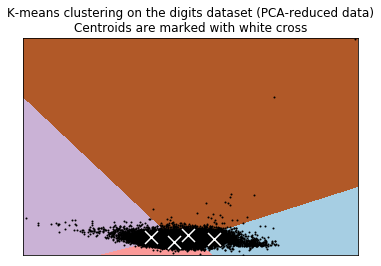

In [19]:
from time import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

X_digits, y_digits = sample, labels
data = scale(X_digits)

n_samples, n_features = data.shape
n_digits = len(np.unique(y_digits))
labels = y_digits

sample_size = 1000

print("n_digits: %d, \t n_samples %d, \t n_features %d"
      % (n_digits, n_samples, n_features))


print(82 * '_')
print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')


def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))

bench_k_means(KMeans(init='k-means++', n_clusters=n_digits, n_init=10),
              name="k-means++", data=data)

bench_k_means(KMeans(init='random', n_clusters=n_digits, n_init=10),
              name="random", data=data)

# in this case the seeding of the centers is deterministic, hence we run the
# kmeans algorithm only once with n_init=1
pca = PCA(n_components=n_digits).fit(data)
bench_k_means(KMeans(init=pca.components_, n_clusters=n_digits, n_init=1),
              name="PCA-based",
              data=data)
print(82 * '_')

# #############################################################################
# Visualize the results on PCA-reduced data

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [196]:
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, kmeans.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, kmeans.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, kmeans.labels_))

Homogeneity: 0.108
Completeness: 0.115
V-measure: 0.111


In [20]:
results = pd.DataFrame()
results['folk'] = np.concatenate((np.ones(n_sample),np.zeros(n_sample),np.zeros(n_sample),np.zeros(n_sample)))
results['electronic'] = np.concatenate((np.zeros(n_sample),np.ones(n_sample),np.zeros(n_sample),np.zeros(n_sample)))
results['rock'] = np.concatenate((np.zeros(n_sample),np.zeros(n_sample),np.ones(n_sample),np.zeros(n_sample)))
results['hiphop'] = np.concatenate((np.zeros(n_sample),np.zeros(n_sample),np.zeros(n_sample),np.ones(n_sample)))
results['pred'] = kmeans.labels_
#results['ones'] = np.full(n_sample*4, 1)
results = results.groupby(['pred']).sum()
results

,folk,electronic,rock,hiphop
pred,,,,
0,1712.0,681.0,1085.0,212.0
1,1166.0,2764.0,1499.0,3934.0
2,537.0,1678.0,1952.0,1488.0
3,2542.0,834.0,1421.0,323.0


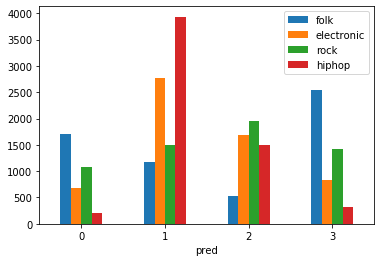

In [21]:
results.plot.bar(rot=0)